In [1]:
# Import Libraries and Load the Data
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Ignore warnings for clean output
warnings.filterwarnings('ignore')

In [2]:
# Data Preparation
data = pd.read_csv('/content/drive/MyDrive/jj.csv', parse_dates=['date'])
data = data.set_index('date')

# Renaming column
data = data.rename(columns={'data': 'Sales'})
print(data.head())
print("Data shape:", data.shape)

            Sales
date             
1960-01-01   0.71
1960-04-01   0.63
1960-07-02   0.85
1960-10-01   0.44
1961-01-01   0.61
Data shape: (84, 1)


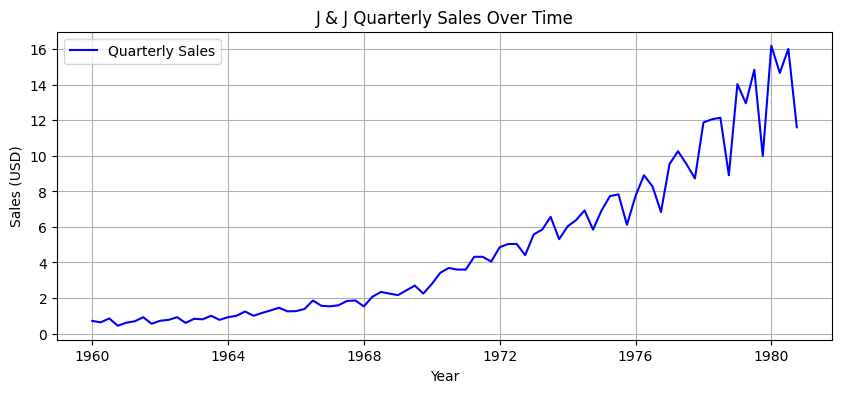

In [3]:
# Visualize the Original Time Series with Grid
plt.figure(figsize=(10, 4))
plt.plot(data.index, data['Sales'], color='blue', label='Quarterly Sales')
plt.title('J & J Quarterly Sales Over Time')
plt.xlabel('Year')
plt.ylabel('Sales (USD)')
plt.legend()
plt.grid(True)
plt.show()

In [4]:
# Stationarity Check (Augmented Dickey-Fuller Test)
result = adfuller(data['Sales'])
print(f"ADF Statistic: {result[0]:.3f}")
print(f"p-value: {result[1]:.3f}")

ADF Statistic: 2.742
p-value: 1.000


In [5]:
# Log Transformation and Differencing
log_sales = np.log(data['Sales'])
log_diff_sales = log_sales.diff().dropna()
result = adfuller(log_diff_sales)
print(f"ADF Statistic after 1st diff (log): {result[0]:.3f}")
print(f"p-value: {result[1]:.4f}")

ADF Statistic after 1st diff (log): -4.317
p-value: 0.0004


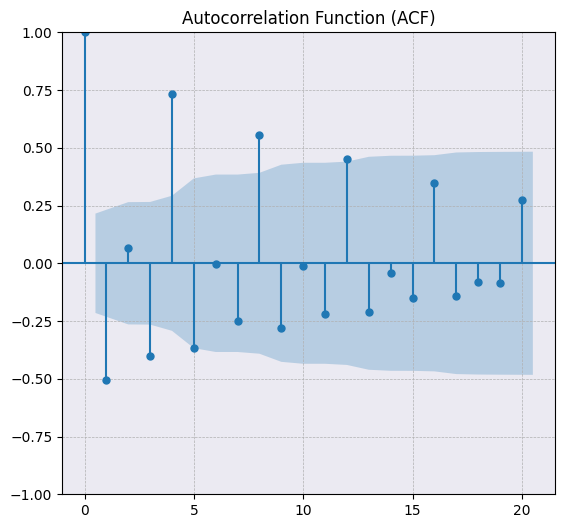

In [6]:
plt.figure(figsize=(14, 6))

# ACF plot
plt.subplot(121)
plot_acf(log_diff_sales, lags=20, ax=plt.gca(), title='Autocorrelation Function (ACF)')
plt.gca().set_facecolor('#EBEAF2')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)  # Add grid lines for better readability

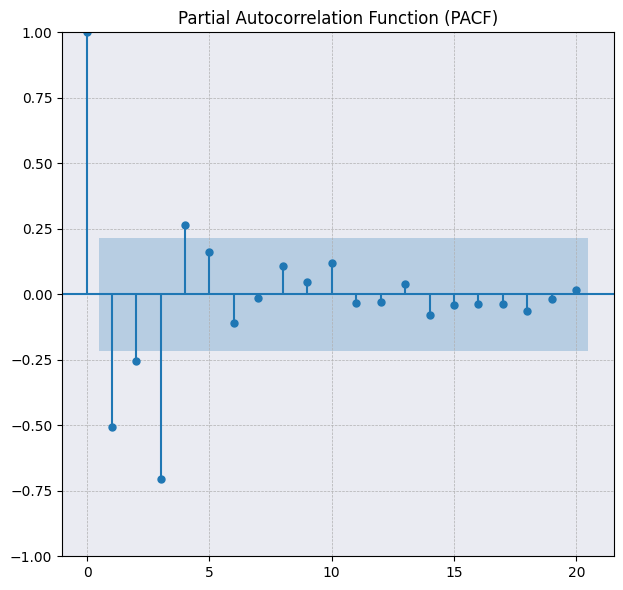

In [7]:
# PACF plot
plt.figure(figsize=(12, 6))

plt.subplot(121)
plot_pacf(log_diff_sales, lags=20, ax=plt.gca(), title='Partial Autocorrelation Function (PACF)')
plt.gca().set_facecolor('#EAEBF2')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

In [8]:
# 🔍 Manual ARIMA(p,d,q) Grid Search Based on AIC
def find_best_arima_model(time_series, max_p=7, max_d=2, max_q=7, verbose=False):
    best_aic = np.inf
    best_order = None

    # Loop through all combinations of p, d, q
    for p in range(max_p + 1):
        for d in range(max_d + 1):
            for q in range(max_q + 1):
                try:
                    model = ARIMA(time_series, order=(p, d, q))
                    model_fit = model.fit()

                    current_aic = model_fit.aic
                    if current_aic < best_aic:
                        best_aic = current_aic
                        best_order = (p, d, q)

                    if verbose:
                        print(f"Checked ARIMA({p},{d},{q}) → AIC: {current_aic:.2f}")

                except Exception as e:
                    if verbose:
                        print(f"Failed ARIMA({p},{d},{q}) → {e}")
                    continue

    return best_order, best_aic


# 🔧 Run the model search
best_order, best_aic = find_best_arima_model(log_sales, max_p=7, max_d=2, max_q=7, verbose=True)

# ✅ Output the result
print(f"\n✅ Best ARIMA Model: {best_order} with AIC: {best_aic:.2f}")

Checked ARIMA(0,0,0) → AIC: 246.23
Checked ARIMA(0,0,1) → AIC: 170.37
Checked ARIMA(0,0,2) → AIC: 81.64
Checked ARIMA(0,0,3) → AIC: 58.78
Checked ARIMA(0,0,4) → AIC: 40.04
Checked ARIMA(0,0,5) → AIC: 17.07
Checked ARIMA(0,0,6) → AIC: -14.11
Checked ARIMA(0,0,7) → AIC: -12.39
Checked ARIMA(0,1,0) → AIC: -20.23
Checked ARIMA(0,1,1) → AIC: -42.27
Checked ARIMA(0,1,2) → AIC: -49.14
Checked ARIMA(0,1,3) → AIC: -56.87
Checked ARIMA(0,1,4) → AIC: -90.24
Checked ARIMA(0,1,5) → AIC: -91.04
Checked ARIMA(0,1,6) → AIC: -91.92
Checked ARIMA(0,1,7) → AIC: -99.56
Checked ARIMA(0,2,0) → AIC: 68.25
Checked ARIMA(0,2,1) → AIC: -14.65
Checked ARIMA(0,2,2) → AIC: -63.71
Checked ARIMA(0,2,3) → AIC: -68.13
Checked ARIMA(0,2,4) → AIC: -45.26
Checked ARIMA(0,2,5) → AIC: -88.28
Checked ARIMA(0,2,6) → AIC: -95.16
Checked ARIMA(0,2,7) → AIC: -104.07
Checked ARIMA(1,0,0) → AIC: -13.51
Checked ARIMA(1,0,1) → AIC: -34.77
Checked ARIMA(1,0,2) → AIC: -41.60
Checked ARIMA(1,0,3) → AIC: -49.37
Checked ARIMA(1,0,4) → A

In [9]:
# 📦 ARIMA Model Fitting
from statsmodels.tsa.arima.model import ARIMA

# 🔧 Fit the ARIMA model using the best order found
print(f"\n📈 Fitting ARIMA Model with order: {best_order} ...")
arima_model = ARIMA(log_sales, order=best_order)
fitted_model = arima_model.fit()

# 🧾 Display the model summary
print("\n📊 ARIMA Model Summary:")
print(fitted_model.summary())


📈 Fitting ARIMA Model with order: (4, 1, 3) ...

📊 ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                   84
Model:                 ARIMA(4, 1, 3)   Log Likelihood                  80.099
Date:                Fri, 11 Apr 2025   AIC                           -144.199
Time:                        23:47:56   BIC                           -124.848
Sample:                             0   HQIC                          -136.425
                                 - 84                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0004      0.060     -0.007      0.994      -0.118       0.117
ar.L2          0.0141      0.049      0.286      0.775    

In [10]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# 📊 Generate in-sample predictions from the ARIMA model
predictions = fitted_model.get_prediction(start=log_sales.index[0], dynamic=False)

# 🔁 Convert log predictions back to original scale
predicted_values = np.exp(predictions.predicted_mean)

# 🎯 Get corresponding actual sales values
actual_values = data.loc[predictions.predicted_mean.index, 'Sales']

# 📐 Evaluation Metrics
mae  = mean_absolute_error(actual_values, predicted_values)
mse  = mean_squared_error(actual_values, predicted_values)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((actual_values - predicted_values) / actual_values)) * 100

# 📝 Display results
print("\n📈 In-Sample Evaluation Metrics:")
print(f"🔹 MAE  (Mean Absolute Error)      : {mae:.2f}")
print(f"🔹 MSE  (Mean Squared Error)       : {mse:.2f}")
print(f"🔹 RMSE (Root Mean Squared Error)  : {rmse:.2f}")
print(f"🔹 MAPE (Mean Absolute % Error)    : {mape:.2f}%")


📈 In-Sample Evaluation Metrics:
🔹 MAE  (Mean Absolute Error)      : 0.28
🔹 MSE  (Mean Squared Error)       : 0.16
🔹 RMSE (Root Mean Squared Error)  : 0.40
🔹 MAPE (Mean Absolute % Error)    : 8.21%


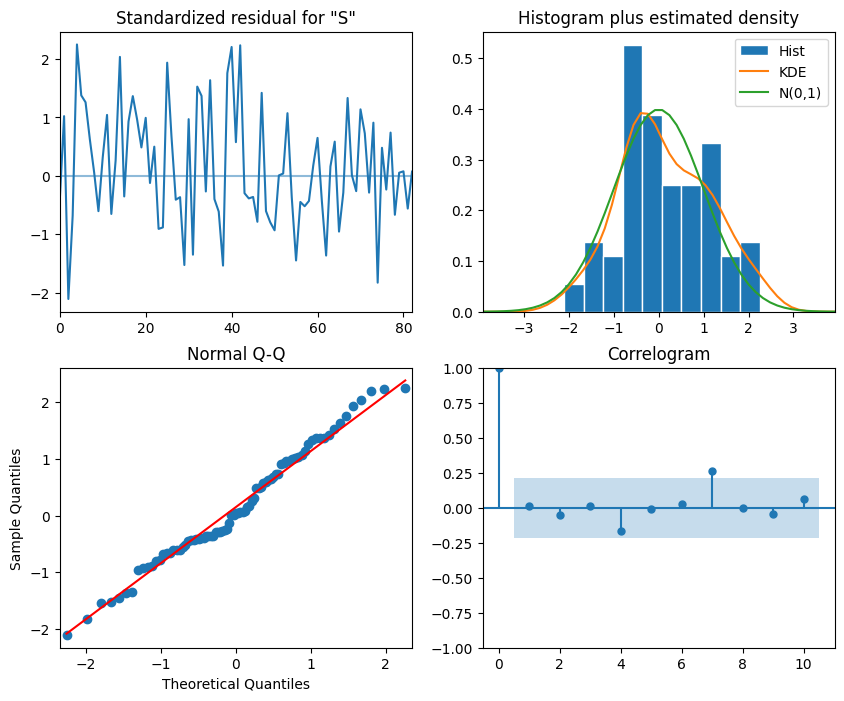

In [11]:
# Residual Diagnostics
fitted_model.plot_diagnostics(figsize=(10, 8))
plt.show()

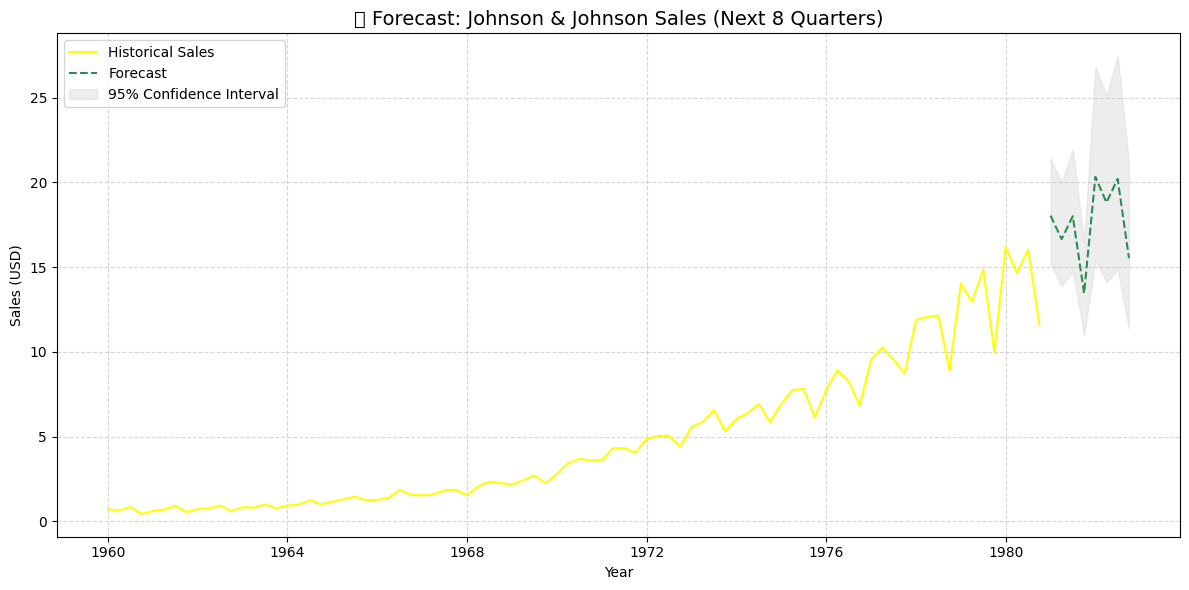

In [12]:
# 📈 Forecasting the Next 8 Quarters
forecast_horizon = 8

# 🔮 Generate log-scale forecast and confidence intervals
forecast_result = fitted_model.get_forecast(steps=forecast_horizon)
forecast_mean_log = forecast_result.predicted_mean
conf_int_log = forecast_result.conf_int()

# 🔁 Convert back to original scale
forecast_mean = np.exp(forecast_mean_log)
forecast_lower = np.exp(conf_int_log.iloc[:, 0])
forecast_upper = np.exp(conf_int_log.iloc[:, 1])

# 🗓️ Create a date index for the forecast
last_date = data.index[-1]
forecast_dates = pd.date_range(start=last_date + pd.offsets.QuarterEnd(), periods=forecast_horizon, freq='Q')

# 🎨 Plot Forecast
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Sales'], label='Historical Sales', color='yellow')
plt.plot(forecast_dates, forecast_mean, label='Forecast', color='seagreen', linestyle='--')
plt.fill_between(forecast_dates, forecast_lower, forecast_upper, color='lightgray', alpha=0.4, label='95% Confidence Interval')

# 🛠️ Final Touches
plt.title('🔮 Forecast: Johnson & Johnson Sales (Next 8 Quarters)', fontsize=14)
plt.xlabel('Year')
plt.ylabel('Sales (USD)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


📈 Forecast Evaluation Metrics:
MAE: LSTM = 1.62, GRU = 1.37
MSE: LSTM = 4.44, GRU = 2.78
RMSE: LSTM = 2.11, GRU = 1.67
MAPE: LSTM = 13.22, GRU = 11.00


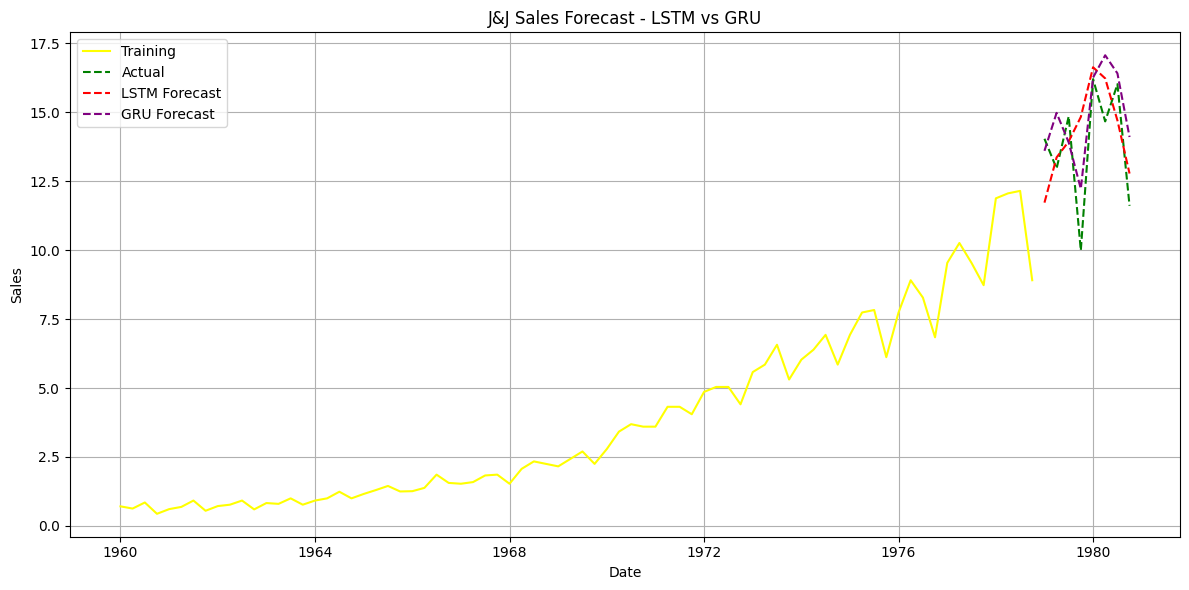

In [13]:
# 📦 Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense
import tensorflow as tf

# 📂 Load and preprocess dataset
def load_data(file_path, test_size=8):
    df = pd.read_csv('/content/drive/MyDrive/jj.csv', parse_dates=['date'], index_col='date')
    series = df['data']
    train = series[:-test_size]
    test = series[-test_size:]
    return train, test, series

# 🔄 Log + Difference to make series stationary
def make_stationary(series):
    log_vals = np.log(series)
    diff_vals = log_vals.diff().dropna()
    return log_vals, diff_vals

# 🧩 Create sequences for supervised learning
def create_sequences(data, seq_len):
    X, y = [], []
    for i in range(seq_len, len(data)):
        X.append(data[i-seq_len:i])
        y.append(data[i])
    return np.array(X), np.array(y)

# 🛠️ Build LSTM or GRU model
def build_model(model_type='lstm', input_shape=(8,1), units=50):
    model = Sequential()
    if model_type == 'lstm':
        model.add(LSTM(units, activation='tanh', input_shape=input_shape))
    else:
        model.add(GRU(units, activation='tanh', input_shape=input_shape))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

# 🔮 Recursive forecasting for n steps
def forecast_recursive(model, last_seq, last_log_val, scaler, n_steps):
    predictions = []
    seq = scaler.transform(last_seq.reshape(-1, 1)).flatten()
    log_val = last_log_val

    for _ in range(n_steps):
        input_ = seq.reshape(1, -1, 1)
        pred_diff = model.predict(input_, verbose=0)[0, 0]
        inv_diff = scaler.inverse_transform([[pred_diff]])[0, 0]
        log_val += inv_diff
        predictions.append(np.exp(log_val))
        seq = np.append(seq[1:], pred_diff)

    return np.array(predictions)

# 📏 Evaluation metrics
def evaluate(true, pred):
    return {
        'MAE': mean_absolute_error(true, pred),
        'MSE': mean_squared_error(true, pred),
        'RMSE': np.sqrt(mean_squared_error(true, pred)),
        'MAPE': np.mean(np.abs((true - pred) / true)) * 100
    }

# 📊 Plot forecasts
def plot_results(train, test, forecasts, labels):
    plt.figure(figsize=(12, 6))
    plt.plot(train.index, train, label='Training', color='yellow')
    plt.plot(test.index, test, label='Actual', color='green', linestyle='--')
    colors = ['red', 'purple']
    for f, label, c in zip(forecasts, labels, colors):
        plt.plot(test.index, f, label=f'{label} Forecast', color=c, linestyle='--')
    plt.title('J&J Sales Forecast - LSTM vs GRU')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# 🚀 Main routine
if __name__ == '__main__':
    FILEPATH = 'jj.csv'
    SEQ_LEN = 8
    TEST_SIZE = 8
    EPOCHS = 100

    np.random.seed(42)
    tf.random.set_seed(42)

    # Load and transform
    train, test, full_series = load_data(FILEPATH, TEST_SIZE)
    log_train, diff_train = make_stationary(train)

    # Create training sequences
    X_train, y_train = create_sequences(diff_train.values, SEQ_LEN)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_train.reshape(-1, 1)).reshape(X_train.shape[0], SEQ_LEN, 1)
    y_scaled = scaler.transform(y_train.reshape(-1, 1)).flatten()

    # Train models
    lstm = build_model('lstm', (SEQ_LEN, 1))
    gru = build_model('gru', (SEQ_LEN, 1))
    lstm.fit(X_scaled, y_scaled, epochs=EPOCHS, verbose=0)
    gru.fit(X_scaled, y_scaled, epochs=EPOCHS, verbose=0)

    # Forecast
    last_seq = diff_train.values[-SEQ_LEN:]
    last_log = log_train.values[-1]
    lstm_pred = forecast_recursive(lstm, last_seq, last_log, scaler, TEST_SIZE)
    gru_pred = forecast_recursive(gru, last_seq, last_log, scaler, TEST_SIZE)

    # Evaluate
    results_lstm = evaluate(test.values, lstm_pred)
    results_gru = evaluate(test.values, gru_pred)

    print("\n📈 Forecast Evaluation Metrics:")
    for metric in results_lstm:
        print(f"{metric}: LSTM = {results_lstm[metric]:.2f}, GRU = {results_gru[metric]:.2f}")

    # Plot
    plot_results(train, test, [lstm_pred, gru_pred], ['LSTM', 'GRU'])

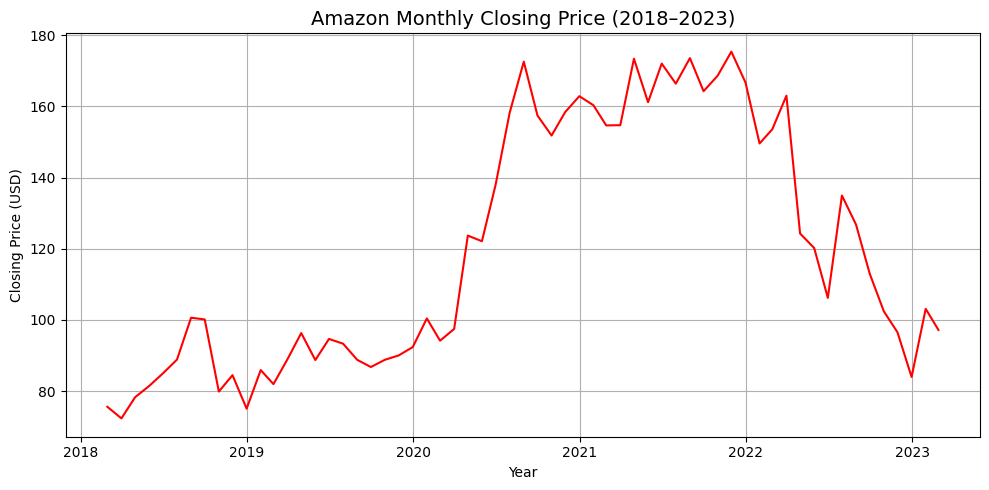

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# 📥 Load and prepare the data
df = pd.read_csv('/content/drive/MyDrive/AMZN.csv', parse_dates=['Date'], index_col='Date')
monthly_close = df['Close'].resample('M').last()  # Use last closing price of each month

# 📊 Plot the monthly closing prices
plt.figure(figsize=(10, 5))
plt.plot(monthly_close, color='red')
plt.title('Amazon Monthly Closing Price (2018–2023)', fontsize=14)
plt.xlabel('Year')
plt.ylabel('Closing Price (USD)')
plt.grid(True)
plt.tight_layout()
plt.show()

In [15]:
result = adfuller(monthly_close.dropna())
print("ADF Statistic:", result[0])
print("p-value:", result[1])

ADF Statistic: -1.5392301342169907
p-value: 0.5140232647833247


In [16]:
from statsmodels.tsa.stattools import adfuller
import numpy as np

# 🔁 Apply log transformation to stabilize variance
log_close = np.log(monthly_close)

# 🧪 Perform Augmented Dickey-Fuller test on log-transformed data
adf_result = adfuller(log_close.dropna())
adf_stat, p_value = adf_result[0], adf_result[1]

# 📋 Display ADF results
print("\n📉 ADF Test on Log-Transformed Amazon Data")
print(f"ADF Statistic  : {adf_stat:.4f}")
print(f"p-value        : {p_value:.4f}")

# 🔍 Interpretation
if p_value < 0.05:
    print("✅ The series is stationary (reject H0)")
else:
    print("❌ The series is NOT stationary (fail to reject H0)")


📉 ADF Test on Log-Transformed Amazon Data
ADF Statistic  : -1.6666
p-value        : 0.4484
❌ The series is NOT stationary (fail to reject H0)


In [17]:
#After log transformation,still p > 0.05,log series remains non-stationary.
#First Differencing (on Log-Transformed Data)
diff_log_close = log_close.diff().dropna()  # 1st difference of log series
result_diff_log = adfuller(diff_log_close)
print("ADF Statistic (log diff):", result_diff_log[0])
print("p-value (log diff):", result_diff_log[1])

ADF Statistic (log diff): -8.920696772064435
p-value (log diff): 1.0430561375247622e-14


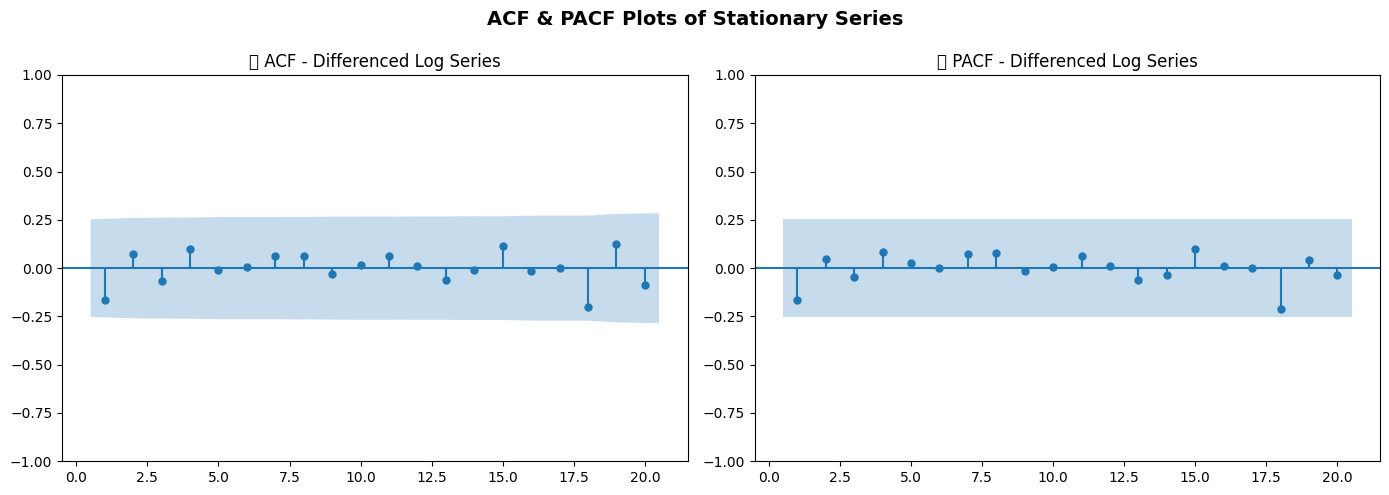

In [18]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# 📊 ACF and PACF of Stationary Series (Log-Differenced)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 🔹 ACF Plot
plot_acf(diff_log_close, ax=axes[0], lags=20, zero=False)
axes[0].set_title('📈 ACF - Differenced Log Series')

# 🔹 PACF Plot
plot_pacf(diff_log_close, ax=axes[1], lags=20, zero=False)
axes[1].set_title('📉 PACF - Differenced Log Series')

# 🎨 Layout & Styling
plt.suptitle('ACF & PACF Plots of Stationary Series', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.subplots_adjust(top=0.85)  # Adjust space for the suptitle
plt.show()

In [19]:
from statsmodels.tsa.arima.model import ARIMA
import numpy as np
import warnings

def search_best_arima(series, max_p=5, max_q=5, d=1, verbose=True):
    """
    Manually search for the best ARIMA(p,d,q) model using AIC.

    Parameters:
        series (pd.Series): Time series data.
        max_p (int): Max AR order.
        max_q (int): Max MA order.
        d (int): Degree of differencing.
        verbose (bool): Print progress if True.

    Returns:
        tuple: (best_order, best_aic)
    """
    best_aic = np.inf
    best_order = None

    warnings.filterwarnings("ignore")

    for p in range(max_p + 1):
        for q in range(max_q + 1):
            try:
                model = ARIMA(series, order=(p, d, q))
                result = model.fit()
                if verbose:
                    print(f"Tested ARIMA({p},{d},{q}) → AIC: {result.aic:.2f}")
                if result.aic < best_aic:
                    best_aic = result.aic
                    best_order = (p, d, q)
            except Exception as e:
                if verbose:
                    print(f"❌ Failed ARIMA({p},{d},{q}): {e}")
                continue

    print(f"\n✅ Best ARIMA Model: {best_order} with AIC: {best_aic:.2f}")
    return best_order, best_aic

# 🔍 Run the grid search
best_order, best_aic = search_best_arima(log_close, max_p=6, max_q=6, d=1)

Tested ARIMA(0,1,0) → AIC: -107.97
Tested ARIMA(0,1,1) → AIC: -107.40
Tested ARIMA(0,1,2) → AIC: -105.61
Tested ARIMA(0,1,3) → AIC: -103.69
Tested ARIMA(0,1,4) → AIC: -102.42
Tested ARIMA(0,1,5) → AIC: -100.42
Tested ARIMA(0,1,6) → AIC: -98.44
Tested ARIMA(1,1,0) → AIC: -107.56
Tested ARIMA(1,1,1) → AIC: -105.99
Tested ARIMA(1,1,2) → AIC: -104.02
Tested ARIMA(1,1,3) → AIC: -102.07
Tested ARIMA(1,1,4) → AIC: -100.42
Tested ARIMA(1,1,5) → AIC: -98.42
Tested ARIMA(1,1,6) → AIC: -97.01
Tested ARIMA(2,1,0) → AIC: -105.73
Tested ARIMA(2,1,1) → AIC: -104.02
Tested ARIMA(2,1,2) → AIC: -102.08
Tested ARIMA(2,1,3) → AIC: -100.26
Tested ARIMA(2,1,4) → AIC: -98.83
Tested ARIMA(2,1,5) → AIC: -96.71
Tested ARIMA(2,1,6) → AIC: -97.35
Tested ARIMA(3,1,0) → AIC: -103.89
Tested ARIMA(3,1,1) → AIC: -102.08
Tested ARIMA(3,1,2) → AIC: -100.20
Tested ARIMA(3,1,3) → AIC: -98.63
Tested ARIMA(3,1,4) → AIC: -96.98
Tested ARIMA(3,1,5) → AIC: -94.83
Tested ARIMA(3,1,6) → AIC: -97.85
Tested ARIMA(4,1,0) → AIC: -10

In [20]:
# Chosen ARIMA(6,1,6) model fit on the log-transformed series for best accuracy plot
model = ARIMA(log_close, order=(6, 1, 6))
results = model.fit()
#Model Summary
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                   61
Model:                 ARIMA(6, 1, 6)   Log Likelihood                  57.427
Date:                Fri, 11 Apr 2025   AIC                            -88.855
Time:                        23:55:20   BIC                            -61.628
Sample:                    02-28-2018   HQIC                           -78.205
                         - 02-28-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3850      1.632     -0.236      0.814      -3.584       2.814
ar.L2          0.5105      1.210      0.422      0.673      -1.861       2.882
ar.L3          1.0116      0.690      1.467      0.1

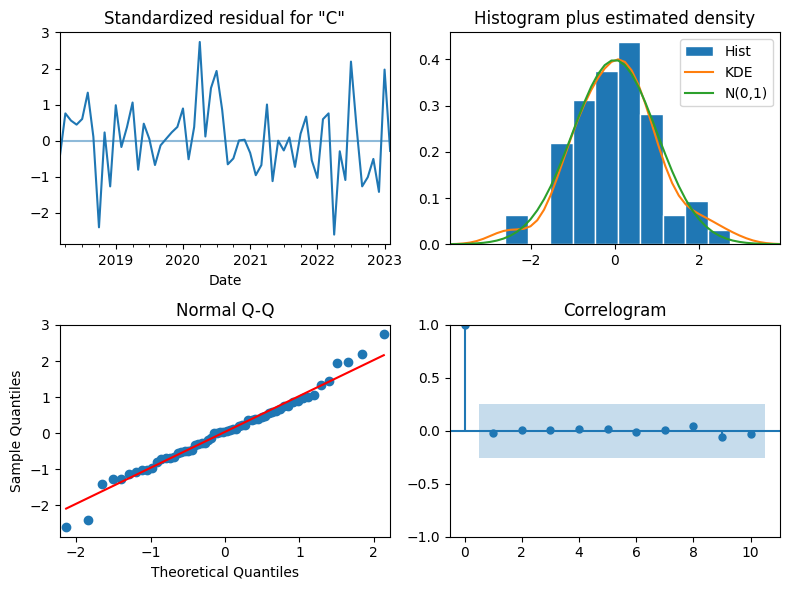

In [21]:
#Diagnostic Plots
results.plot_diagnostics(figsize=(8,6))
plt.tight_layout()
plt.show()

In [22]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# 📈 Generate in-sample predictions (on log scale)
in_sample_pred = results.get_prediction(start=log_close.index[0], dynamic=False)
log_predicted = in_sample_pred.predicted_mean

# 🔁 Convert predictions back to original scale
predicted = np.exp(log_predicted)
actual = monthly_close.loc[log_predicted.index]

# 📊 Calculate evaluation metrics
mae = mean_absolute_error(actual, predicted)
mse = mean_squared_error(actual, predicted)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((actual - predicted) / actual)) * 100

# 📝 Display results
print("\n📊 In-Sample Model Evaluation Metrics")
print(f"🔹 MAE  (Mean Absolute Error)     : ${mae:.2f}")
print(f"🔹 MSE  (Mean Squared Error)      : ${mse:.2f}")
print(f"🔹 RMSE (Root Mean Squared Error) : ${rmse:.2f}")
print(f"🔹 MAPE (Mean Absolute % Error)   : {mape:.2f}%")


📊 In-Sample Model Evaluation Metrics
🔹 MAE  (Mean Absolute Error)     : $9.47
🔹 MSE  (Mean Squared Error)      : $213.95
🔹 RMSE (Root Mean Squared Error) : $14.63
🔹 MAPE (Mean Absolute % Error)   : 8.56%


First 5 forecasted log values:
2023-03-31    4.570603
2023-04-30    4.553485
2023-05-31    4.567387
2023-06-30    4.543761
2023-07-31    4.533624
Freq: ME, Name: predicted_mean, dtype: float64
First 5 forecasted original scale values:
2023-03-31    96.602359
2023-04-30    94.962781
2023-05-31    96.292195
2023-06-30    94.043873
2023-07-31    93.095322
Freq: ME, Name: predicted_mean, dtype: float64


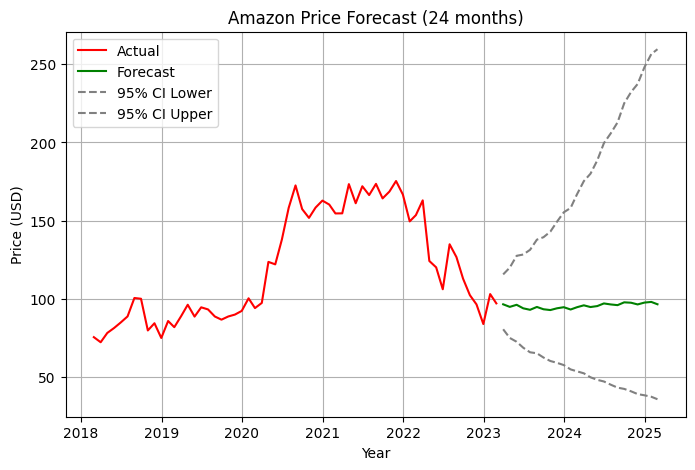

In [23]:
# Generate forecasts for the next 24 months (in log scale)
# Convert the forecast mean and confidence interval to original scale

def forecast_and_convert(model_results, steps):
    """
 Using a fitted ARIMA model, create projections for a specified number of steps in the future and translate the findings from log scale to original scale.


     Parameters: model_results (ARIMAResults): The ARIMA model that was fitted and used for forecasting.
     steps (int): The quantity of upcoming actions to predict.

     The predicted mean values and confidence intervals for both scales are contained in the returns, which are a tuple.

    """
    # Generate forecasts in log scale
    forecast_log = model_results.get_forecast(steps=steps)
    log_forecast_mean = forecast_log.predicted_mean  # predicted log values
    log_conf_int = forecast_log.conf_int()           # confidence intervals in log scale

    # Convert the forecast and confidence intervals to original scale
    forecast_mean = np.exp(log_forecast_mean)  # Convert mean to original scale
    conf_lower = np.exp(log_conf_int.iloc[:, 0])  # Convert lower bound
    conf_upper = np.exp(log_conf_int.iloc[:, 1])  # Convert upper bound

    # Optionally, print the first few values to check
    print("First 5 forecasted log values:")
    print(log_forecast_mean[:5])
    print("First 5 forecasted original scale values:")
    print(forecast_mean[:5])

    return (log_forecast_mean, log_conf_int, forecast_mean, conf_lower, conf_upper)


log_forecast_mean, log_conf_int, forecast_mean, conf_lower, conf_upper = forecast_and_convert(results, 24)
#plot actual vs forecast with intervals
plt.figure(figsize=(8,5))
plt.plot(monthly_close.index, monthly_close.values, label='Actual', color='red')
plt.plot(forecast_mean.index, forecast_mean.values, label='Forecast', color='green')
plt.plot(forecast_mean.index, conf_lower, color='gray', linestyle='--', label='95% CI Lower')
plt.plot(forecast_mean.index, conf_upper, color='gray', linestyle='--', label='95% CI Upper')
plt.title('Amazon Price Forecast (24 months)')
plt.xlabel('Year'); plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

In [24]:
import pandas as pd

# 📥 Load and process the Amazon stock data
def load_amazon_monthly_prices(filepath="/content/drive/MyDrive/AMZN.csv"):
    # Load the dataset and parse dates
    df = pd.read_csv(filepath, parse_dates=['Date'], index_col='Date')

    # 🗓 Resample to monthly frequency, taking the last closing price of each month
    monthly_close = df['Close'].resample('M').last()

    # 📋 Display summary
    print(f"📅 Date Range      : {monthly_close.index.min().date()} to {monthly_close.index.max().date()}")
    print(f"🔢 Data Points     : {len(monthly_close)} months\n")
    print("📌 First 3 Monthly Prices:\n", monthly_close.head(3))

    return monthly_close

# Run the function
monthly_df = load_amazon_monthly_prices()

📅 Date Range      : 2018-02-28 to 2023-02-28
🔢 Data Points     : 61 months

📌 First 3 Monthly Prices:
 Date
2018-02-28    75.622498
2018-03-31    72.366997
2018-04-30    78.306503
Freq: ME, Name: Close, dtype: float64


In [25]:
# Apply log transformation to the monthly closing prices
log_series = np.log(monthly_df)

# Apply first-order differencing to the log-transformed series
diff_series = log_series.diff().dropna()

# Define the split point: last 24 months for testing
train_series = monthly_df.iloc[:-24]  # all data except last 24 points
test_series  = monthly_df.iloc[-24:]  # last 24 months for test

# Differenced log series for the training period and testing period
train_diff = diff_series[:train_series.index.max()]  # up to Feb 2021 diff
test_diff  = diff_series[test_series.index.min():]   # from Mar 2021 diff onward

window_size = 12
train_diff_values = train_diff.values  # numpy array of training differenced log values

X = []
y = []
# Sliding window: use past 12 values to predict the next value
for i in range(window_size, len(train_diff_values)):
    X.append(train_diff_values[i-window_size:i])  # 12 values
    y.append(train_diff_values[i])               # next value

X = np.array(X)
y = np.array(y)

from sklearn.preprocessing import StandardScaler

# Initialize scaler and fit on training differenced values (reshaped to column vector)
scaler = StandardScaler()
scaler.fit(train_diff_values.reshape(-1, 1))

# Transform the input sequences and target values
X_scaled = scaler.transform(X.reshape(-1, 1)).reshape(X.shape)
y_scaled = scaler.transform(y.reshape(-1, 1)).flatten()

print("Mean of training diffs (for scaling):", scaler.mean_[0])
print("Std of training diffs (for scaling):", np.sqrt(scaler.var_[0]))
print("First scaled input sample:\n", X_scaled[0])
print("First scaled target value:\n", y_scaled[0])

X_scaled = X_scaled.reshape((X_scaled.shape[0], X_scaled.shape[1], 1))
print("Reshaped X_scaled for RNN input:", X_scaled.shape)

Mean of training diffs (for scaling): 0.019871889878324406
Std of training diffs (for scaling): 0.08431030220061811
First scaled input sample:
 [-0.75762234  0.69989559  0.23564569  0.26440171  0.29405287  1.23870999
 -0.29305868 -2.9149332   0.42934428 -1.63590179  1.36325152 -0.7930817 ]
First scaled target value:
 0.7421408745953508
Reshaped X_scaled for RNN input: (24, 12, 1)


In [26]:
#Building and Training the RNN Models (LSTM & GRU)
# Set random seeds for reproducibility
import tensorflow as tf
np.random.seed(0)
tf.random.set_seed(0)

# Build LSTM model
lstm_model = Sequential([
    LSTM(50, activation='relu', input_shape=(window_size, 1)),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Build GRU model
gru_model = Sequential([
    GRU(50, activation='relu', input_shape=(window_size, 1)),
    Dense(1)
])
gru_model.compile(optimizer='adam', loss='mean_squared_error')

# Train both models for a fixed number of epochs
epochs = 100
history_lstm = lstm_model.fit(X_scaled, y_scaled, epochs=epochs, verbose=0)
history_gru  = gru_model.fit(X_scaled, y_scaled, epochs=epochs, verbose=0)

# Print final training losses
print("LSTM final training loss:", history_lstm.history['loss'][-1])
print("GRU final training loss:", history_gru.history['loss'][-1])

LSTM final training loss: 0.29193899035453796
GRU final training loss: 0.20425839722156525


In [27]:
def forecast(model, initial_log, initial_diffs, scaler, forecast_horizon, window_size):
    """Generalized function to perform forecasting using either LSTM or GRU."""
    predictions = []
    current_log = initial_log
    current_diffs = initial_diffs.copy()

    for _ in range(forecast_horizon):
        # Scale the input sequence and reshape for the model
        input_seq = scaler.transform(current_diffs.reshape(-1,1)).reshape(1, window_size, 1)
        # Predict the next log difference and reverse scaling
        pred_scaled_diff = model.predict(input_seq, verbose=0)
        pred_diff = scaler.inverse_transform(pred_scaled_diff)[0, 0]

        # Update the log price and calculate the actual price
        current_log += pred_diff
        predictions.append(np.exp(current_log))

        # Update the differences array for the next step
        current_diffs = np.concatenate([current_diffs[1:], [pred_diff]])

    return predictions

# Configuration
forecast_horizon = 24
window_size = 12  # Assuming window_size is defined as 12 for your models

# Fetch the last known log value and the last 12 differences from the training data
last_log = log_series[train_series.index.max()]
last_12_diffs = train_diff[-12:].values

# Forecast using both LSTM and GRU models
predictions_lstm = forecast(lstm_model, last_log, last_12_diffs, scaler, forecast_horizon, window_size)
predictions_gru = forecast(gru_model, last_log, last_12_diffs, scaler, forecast_horizon, window_size)

# Convert predictions to Pandas series for easy handling
forecast_dates = pd.date_range(start=train_series.index.max() + pd.DateOffset(months=1), periods=forecast_horizon, freq='M')
pred_series_lstm = pd.Series(predictions_lstm, index=forecast_dates)
pred_series_gru = pd.Series(predictions_gru, index=forecast_dates)

# Display the first few predictions from both models
print("First 3 Predictions LSTM:")
print(pred_series_lstm.head(3))
print("\nFirst 3 Predictions GRU:")
print(pred_series_gru.head(3))

First 3 Predictions LSTM:
2021-03-31    158.883127
2021-04-30    161.018228
2021-05-31    166.904671
Freq: ME, dtype: float64

First 3 Predictions GRU:
2021-03-31    158.521962
2021-04-30    164.304153
2021-05-31    168.520258
Freq: ME, dtype: float64


In [28]:
# Calculate evaluation metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Convert test series to numpy array for compatibility
actual_prices = test_series.values
lstm_predictions = pred_series_lstm.values
gru_predictions = pred_series_gru.values

# LSTM Metrics
mae_lstm = mean_absolute_error(actual_prices, lstm_predictions)
mse_lstm = mean_squared_error(actual_prices, lstm_predictions)
rmse_lstm = np.sqrt(mse_lstm)
mape_lstm = np.mean(np.abs((actual_prices - lstm_predictions) / actual_prices)) * 100

# GRU Metrics
mae_gru = mean_absolute_error(actual_prices, gru_predictions)
mse_gru = mean_squared_error(actual_prices, gru_predictions)
rmse_gru = np.sqrt(mse_gru)
mape_gru = np.mean(np.abs((actual_prices - gru_predictions) / actual_prices)) * 100

print("\nModel Performance Comparison:")
print(f"{'Metric':<10} {'LSTM':<15} {'GRU':<15}")
print(f"{'MAE':<10} ${mae_lstm:.2f}{'':<8} ${mae_gru:.2f}")
print(f"{'MSE':<10} ${mse_lstm:.2f}{'':<8} ${mse_gru:.2f}")
print(f"{'RMSE':<10} ${rmse_lstm:.2f}{'':<8} ${rmse_gru:.2f}")
print(f"{'MAPE (%)':<10} {mape_lstm:.2f}%{'':<6} {mape_gru:.2f}%")


Model Performance Comparison:
Metric     LSTM            GRU            
MAE        $209.93         $102.83
MSE        $81179.54         $18262.24
RMSE       $284.92         $135.14
MAPE (%)   187.02%       92.70%


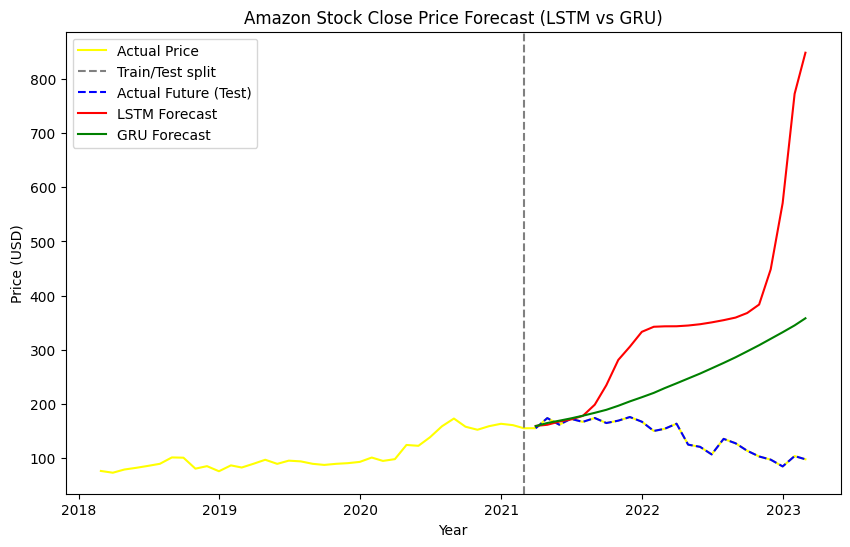

In [29]:
# Plot Amazon Stock Close Price Forecast (LSTM vs GRU)
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(monthly_df.index, monthly_df.values, label='Actual Price', color='yellow')
plt.axvline(x=train_series.index[-1], color='gray', linestyle='--', label='Train/Test split')
plt.plot(test_series.index, test_series.values, label='Actual Future (Test)', color='blue', linestyle='--')
plt.plot(pred_series_lstm.index, pred_series_lstm.values, label='LSTM Forecast', color='red')
plt.plot(pred_series_gru.index, pred_series_gru.values, label='GRU Forecast', color='green')
plt.title('Amazon Stock Close Price Forecast (LSTM vs GRU)')
plt.xlabel('Year')
plt.ylabel('Price (USD)')
plt.legend(loc='upper left')
plt.show()